In [1]:
# imports
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
import env
from env import username, password, host

import wrangle as w
import os
directory = os.getcwd()

In [2]:
url = f'mysql+pymysql://{env.username}:{env.password}@{env.host}/grocery_db'
query = '''
select *
from grocery_customers;
'''
df = pd.read_sql(query, url)
print(df.shape)
df

(440, 9)


,customer_id,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0,2,3,12669,9656,7561,214,2674,1338
1,1,2,3,7057,9810,9568,1762,3293,1776
2,2,2,3,6353,8808,7684,2405,3516,7844
3,3,1,3,13265,1196,4221,6404,507,1788
4,4,2,3,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...,...,...,...
435,435,1,3,29703,12051,16027,13135,182,2204
436,436,1,3,39228,1431,764,4510,93,2346
437,437,2,3,14531,15488,30243,437,14841,1867
438,438,1,3,10290,1981,2232,1038,168,2125


In [3]:
# Cluster on all or a selected subset of features
grocery_milk_fresh = df[["Grocery", "Milk", "Fresh"]]
grocery_milk_fresh.head(2)

,Grocery,Milk,Fresh
0,7561,9656,12669
1,9568,9810,7057


In [4]:
# Make the scaler
scaler = MinMaxScaler()

# Fit the scaler
scaler.fit(grocery_milk_fresh)

# Use the scaler
grocery_milk_fresh = scaler.transform(grocery_milk_fresh)
grocery_milk_fresh


array([[0.08146416, 0.13072723, 0.11294004],
       [0.10309667, 0.13282409, 0.06289903],
       [0.08278992, 0.11918086, 0.05662161],
       ...,
       [0.32594285, 0.21013575, 0.1295431 ],
       [0.02402535, 0.02622442, 0.091727  ],
       [0.02702178, 0.02237109, 0.02482434]])

In [5]:
# Make the object
dbsc = DBSCAN(eps = .125, min_samples = 10)

# Fit the object
dbsc.fit(grocery_milk_fresh)


DBSCAN(eps=0.125, min_samples=10)

In [6]:
# Now, let's add the scaled value columns back onto the dataframe
columns = ["Grocery", "Milk", "Fresh"]
scaled_columns = ["Scaled_" + column for column in columns]

# Save a copy of the original dataframe
original_df = df.copy()

# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(grocery_milk_fresh, columns=scaled_columns)

# Reset index on both dataframes to merge on index
df = df.reset_index()
scaled_df = scaled_df.reset_index()

# Merge the scaled and non-scaled values into one dataframe
df = df.merge(scaled_df, on='index')

# Drop the 'index' column as it's no longer needed
df = df.drop(columns=['index'])

# Display the first few rows of the dataframe
df.head()


,customer_id,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Scaled_Grocery,Scaled_Milk,Scaled_Fresh
0,0,2,3,12669,9656,7561,214,2674,1338,0.081464,0.130727,0.112940
1,1,2,3,7057,9810,9568,1762,3293,1776,0.103097,0.132824,0.062899
2,2,2,3,6353,8808,7684,2405,3516,7844,0.082790,0.119181,0.056622
3,3,1,3,13265,1196,4221,6404,507,1788,0.045464,0.015536,0.118254
4,4,2,3,22615,5410,7198,3915,1777,5185,0.077552,0.072914,0.201626


In [7]:
# Assign the cluster labels
# Recall that cluster labels don't have inherent meaning
# DBSCAN makes a cluster called -1 that contains the "noise" or outliers
df['labels'] = dbsc.labels_
df.labels.value_counts()


 0    427
-1     13
Name: labels, dtype: int64

In [8]:
df.head()


,customer_id,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Scaled_Grocery,Scaled_Milk,Scaled_Fresh,labels
0,0,2,3,12669,9656,7561,214,2674,1338,0.081464,0.130727,0.112940,0
1,1,2,3,7057,9810,9568,1762,3293,1776,0.103097,0.132824,0.062899,0
2,2,2,3,6353,8808,7684,2405,3516,7844,0.082790,0.119181,0.056622,0
3,3,1,3,13265,1196,4221,6404,507,1788,0.045464,0.015536,0.118254,0
4,4,2,3,22615,5410,7198,3915,1777,5185,0.077552,0.072914,0.201626,0


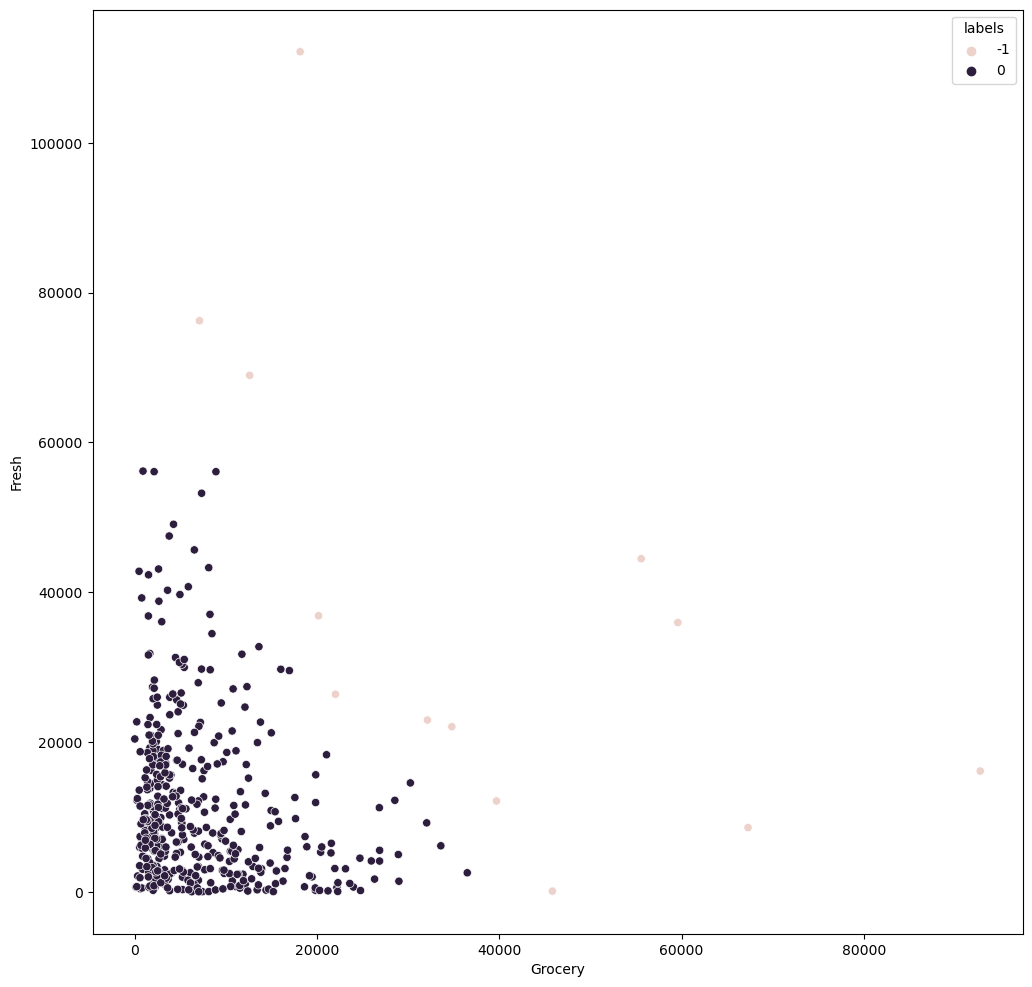

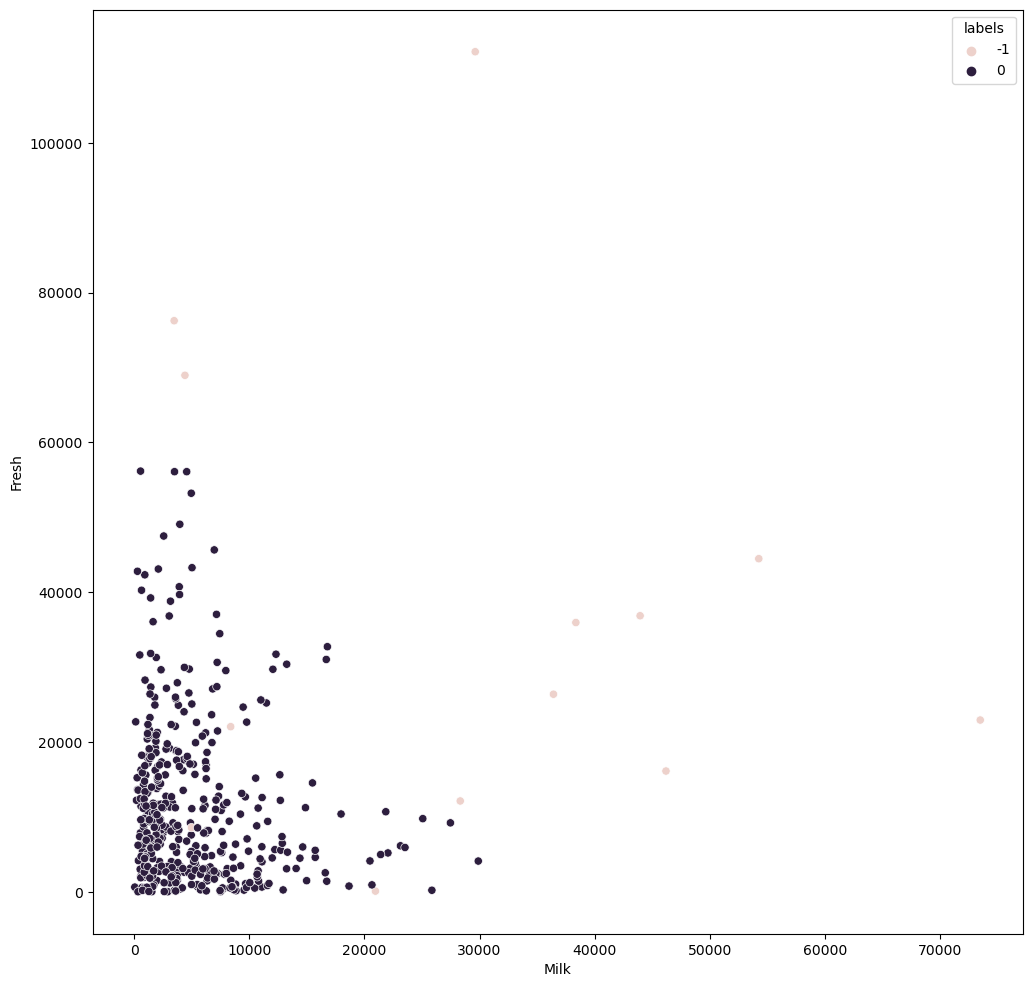

In [9]:
plt.figure(figsize=(12,12))
sns.scatterplot(x=df.Grocery, y=df.Fresh, hue=df.labels)
plt.show()

plt.figure(figsize=(12,12))
sns.scatterplot(x=df.Milk, y=df.Fresh, hue=df.labels)
plt.show()


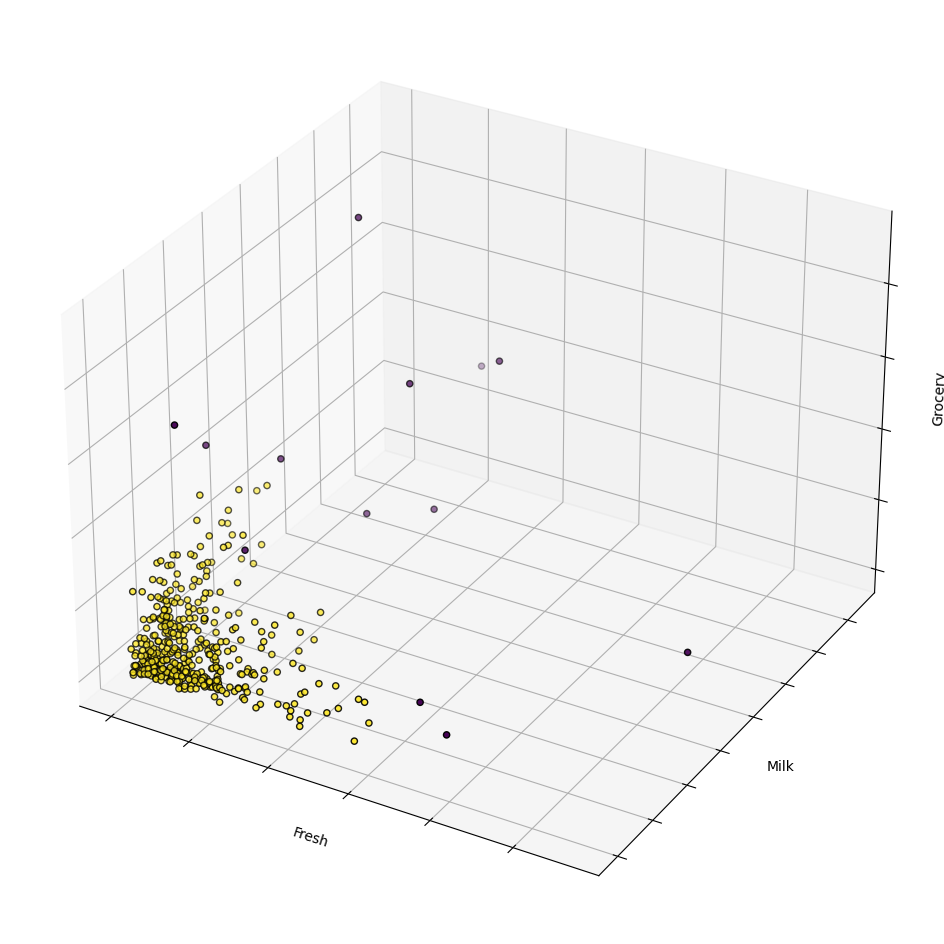

In [10]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# plot the points
ax.scatter(df['Fresh'], df['Milk'], df['Grocery'], c=df['labels'], edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('Fresh')
ax.set_ylabel('Milk')
ax.set_zlabel('Grocery')

plt.show()

In [11]:
url = f'mysql+pymysql://{env.username}:{env.password}@{env.host}/grocery_db'
query = '''
select *
from grocery_customers;
'''
df = pd.read_sql(query, url)
print(df.shape)
df

(440, 9)


,customer_id,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0,2,3,12669,9656,7561,214,2674,1338
1,1,2,3,7057,9810,9568,1762,3293,1776
2,2,2,3,6353,8808,7684,2405,3516,7844
3,3,1,3,13265,1196,4221,6404,507,1788
4,4,2,3,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...,...,...,...
435,435,1,3,29703,12051,16027,13135,182,2204
436,436,1,3,39228,1431,764,4510,93,2346
437,437,2,3,14531,15488,30243,437,14841,1867
438,438,1,3,10290,1981,2232,1038,168,2125


In [12]:
# Cluster on all or a selected subset of features
frozen_detergents_deli = df[["Frozen", "Detergents_Paper", "Delicassen"]]
frozen_detergents_deli.head(2)

,Frozen,Detergents_Paper,Delicassen
0,214,2674,1338
1,1762,3293,1776


In [13]:
# Make the scaler
scaler = MinMaxScaler()

# Fit the scaler
scaler.fit(frozen_detergents_deli)

# Use the scaler
frozen_detergents_deli = scaler.transform(frozen_detergents_deli)
frozen_detergents_deli


array([[0.0031063 , 0.0654272 , 0.02784731],
       [0.02854842, 0.08058985, 0.03698373],
       [0.03911643, 0.08605232, 0.16355861],
       ...,
       [0.00677142, 0.36346267, 0.03888194],
       [0.01664914, 0.00404174, 0.04426366],
       [0.00065742, 0.01161082, 0.00102211]])

In [14]:
# Make the object
dbsc = DBSCAN(eps = .05, min_samples = 5)

# Fit the object
dbsc.fit(frozen_detergents_deli)


DBSCAN(eps=0.05)

In [15]:
# Now, let's add the scaled value columns back onto the dataframe
columns = ["Frozen", "Detergents_Paper", "Delicassen"]
scaled_columns = ["Scaled_" + column for column in columns]

# Save a copy of the original dataframe
original_df = df.copy()

# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(frozen_detergents_deli, columns=scaled_columns)

# Reset index on both dataframes to merge on index
df = df.reset_index()
scaled_df = scaled_df.reset_index()

# Merge the scaled and non-scaled values into one dataframe
df = df.merge(scaled_df, on='index')

# Drop the 'index' column as it's no longer needed
df = df.drop(columns=['index'])

# Display the first few rows of the dataframe
df.head()


,customer_id,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Scaled_Frozen,Scaled_Detergents_Paper,Scaled_Delicassen
0,0,2,3,12669,9656,7561,214,2674,1338,0.003106,0.065427,0.027847
1,1,2,3,7057,9810,9568,1762,3293,1776,0.028548,0.080590,0.036984
2,2,2,3,6353,8808,7684,2405,3516,7844,0.039116,0.086052,0.163559
3,3,1,3,13265,1196,4221,6404,507,1788,0.104842,0.012346,0.037234
4,4,2,3,22615,5410,7198,3915,1777,5185,0.063934,0.043455,0.108093


In [16]:
# Assign the cluster labels
# Recall that cluster labels don't have inherent meaning
# DBSCAN makes a cluster called -1 that contains the "noise" or outliers
df['labels'] = dbsc.labels_
df.labels.value_counts()


 0    403
-1     23
 1     14
Name: labels, dtype: int64

In [17]:
df.head()


,customer_id,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Scaled_Frozen,Scaled_Detergents_Paper,Scaled_Delicassen,labels
0,0,2,3,12669,9656,7561,214,2674,1338,0.003106,0.065427,0.027847,0
1,1,2,3,7057,9810,9568,1762,3293,1776,0.028548,0.080590,0.036984,0
2,2,2,3,6353,8808,7684,2405,3516,7844,0.039116,0.086052,0.163559,-1
3,3,1,3,13265,1196,4221,6404,507,1788,0.104842,0.012346,0.037234,0
4,4,2,3,22615,5410,7198,3915,1777,5185,0.063934,0.043455,0.108093,0


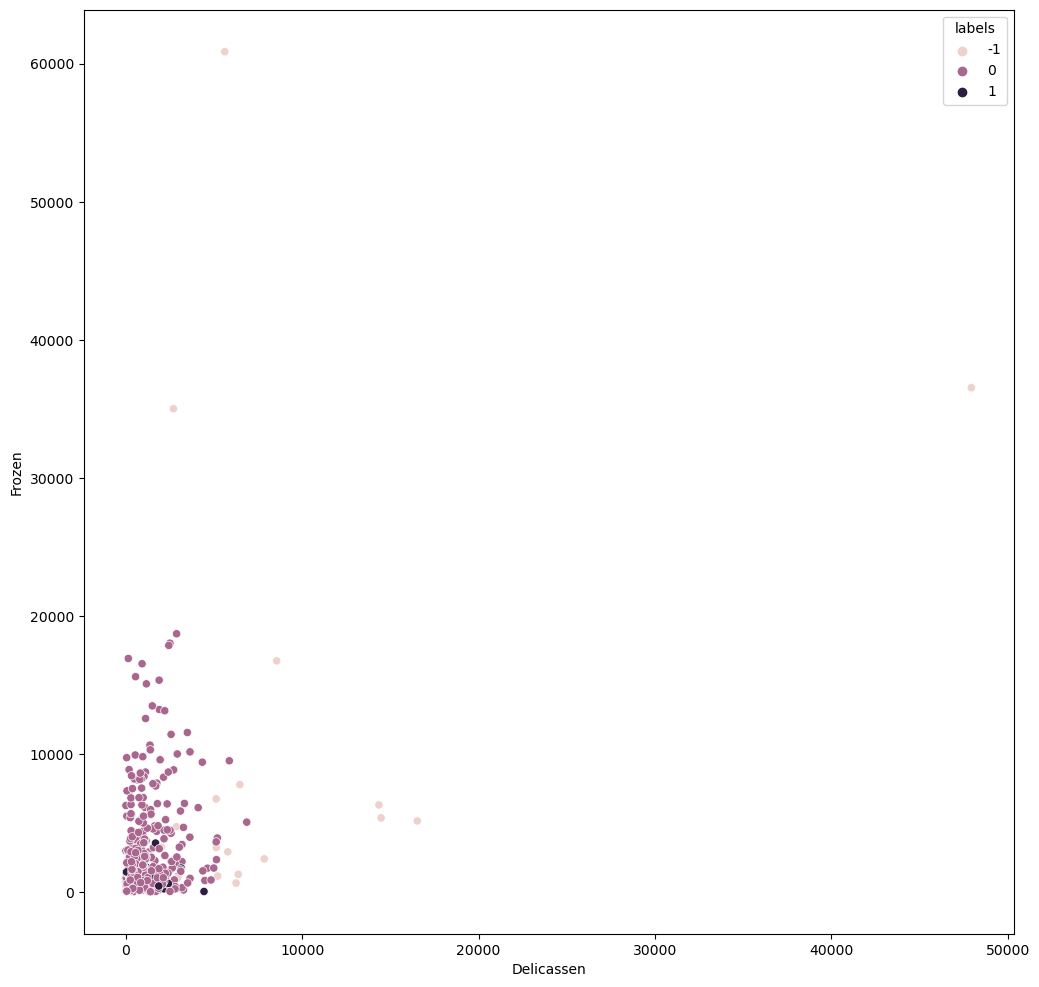

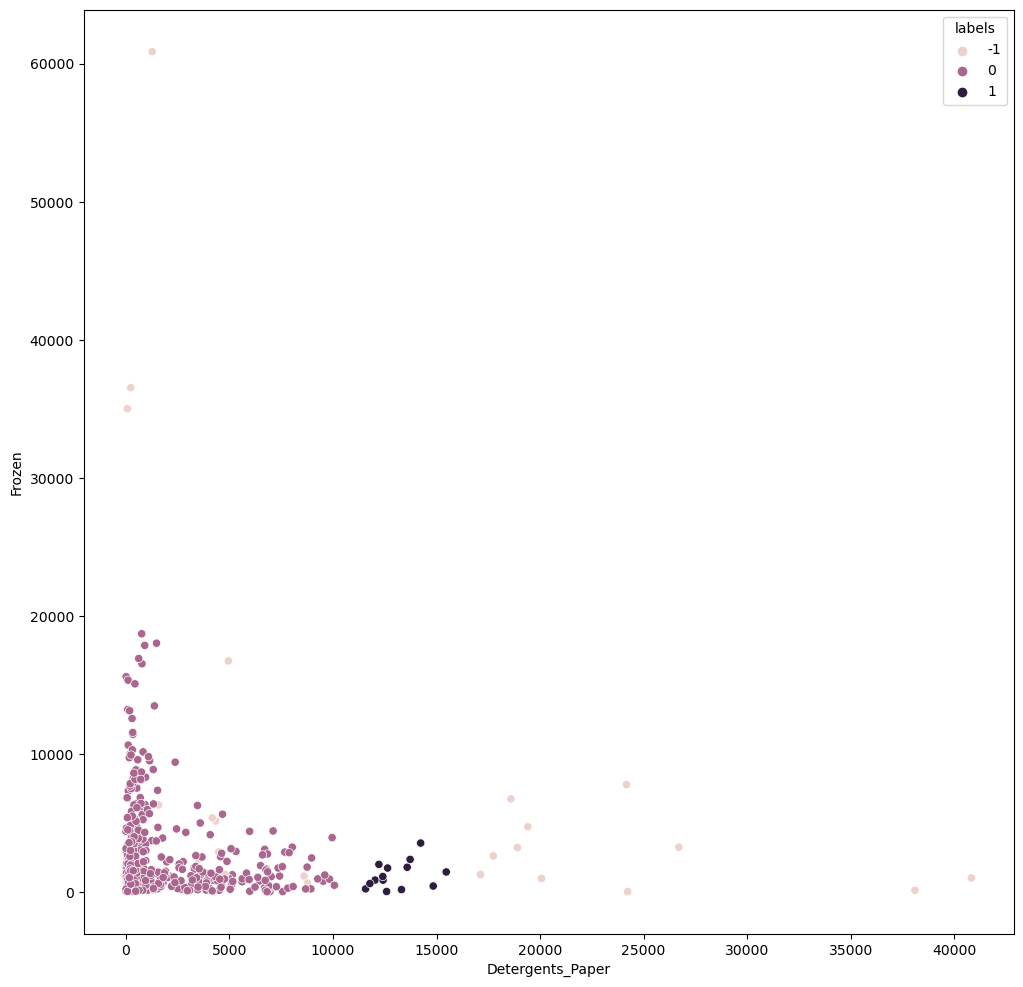

In [18]:
plt.figure(figsize=(12,12))
sns.scatterplot(x=df.Delicassen, y=df.Frozen, hue=df.labels)
plt.show()

plt.figure(figsize=(12,12))
sns.scatterplot(x=df.Detergents_Paper, y=df.Frozen, hue=df.labels)
plt.show()


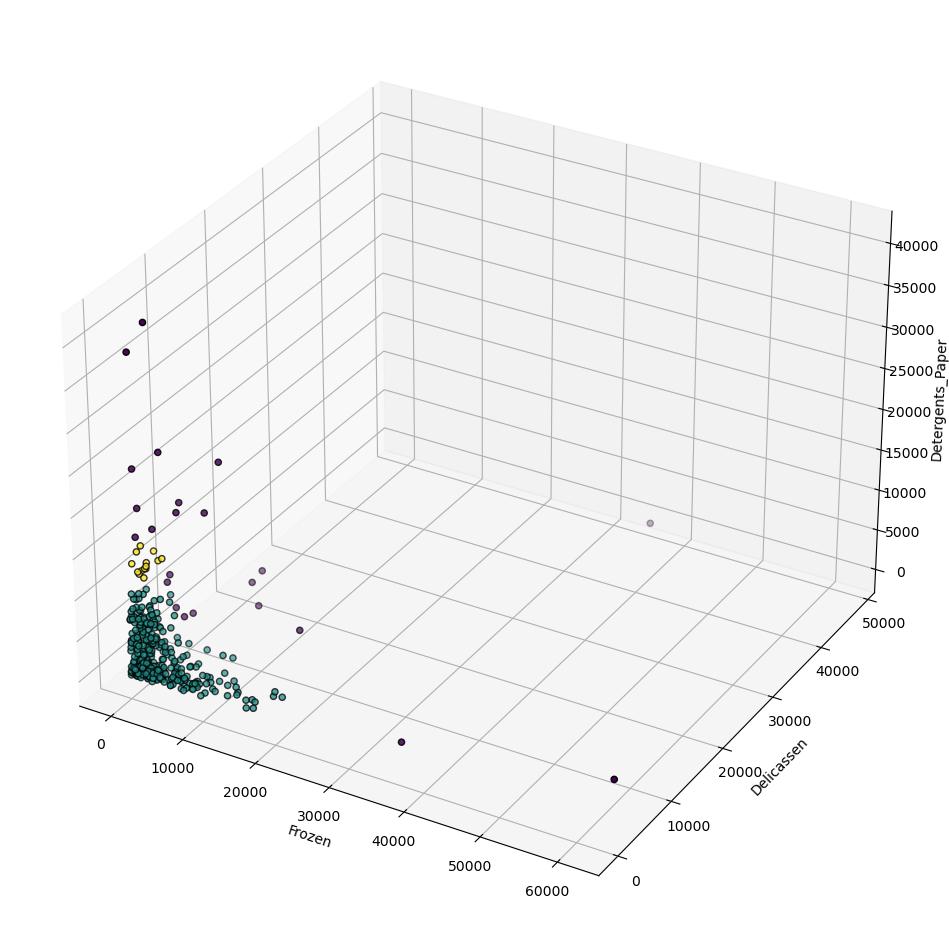

In [19]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# plot the points
ax.scatter(df['Frozen'], df['Delicassen'], df['Detergents_Paper'], c=df['labels'], edgecolor='k')

ax.set_xlabel('Frozen')
ax.set_ylabel('Delicassen')
ax.set_zlabel('Detergents_Paper')

plt.show()


In [20]:
url = f'mysql+pymysql://{env.username}:{env.password}@{env.host}/grocery_db'
query = '''
select *
from grocery_customers;
'''
df = pd.read_sql(query, url)
print(df.shape)
df

(440, 9)


,customer_id,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0,2,3,12669,9656,7561,214,2674,1338
1,1,2,3,7057,9810,9568,1762,3293,1776
2,2,2,3,6353,8808,7684,2405,3516,7844
3,3,1,3,13265,1196,4221,6404,507,1788
4,4,2,3,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...,...,...,...
435,435,1,3,29703,12051,16027,13135,182,2204
436,436,1,3,39228,1431,764,4510,93,2346
437,437,2,3,14531,15488,30243,437,14841,1867
438,438,1,3,10290,1981,2232,1038,168,2125


In [21]:
# Cluster on all or a selected subset of features
frozen_detergents_deli = df[["Frozen", "Detergents_Paper", "Delicassen"]]
frozen_detergents_deli.head(2)

,Frozen,Detergents_Paper,Delicassen
0,214,2674,1338
1,1762,3293,1776


In [22]:
# Make the scaler
scaler = MinMaxScaler()

# Fit the scaler
scaler.fit(frozen_detergents_deli)

# Use the scaler
frozen_detergents_deli = scaler.transform(frozen_detergents_deli)
frozen_detergents_deli


array([[0.0031063 , 0.0654272 , 0.02784731],
       [0.02854842, 0.08058985, 0.03698373],
       [0.03911643, 0.08605232, 0.16355861],
       ...,
       [0.00677142, 0.36346267, 0.03888194],
       [0.01664914, 0.00404174, 0.04426366],
       [0.00065742, 0.01161082, 0.00102211]])

In [23]:
# Make the object
dbsc = DBSCAN(eps = .1, min_samples = 8)

# Fit the object
dbsc.fit(frozen_detergents_deli)


DBSCAN(eps=0.1, min_samples=8)

In [24]:
# Now, let's add the scaled value columns back onto the dataframe
columns = ["Frozen", "Detergents_Paper", "Delicassen"]
scaled_columns = ["Scaled_" + column for column in columns]

# Save a copy of the original dataframe
original_df = df.copy()

# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(frozen_detergents_deli, columns=scaled_columns)

# Reset index on both dataframes to merge on index
df = df.reset_index()
scaled_df = scaled_df.reset_index()

# Merge the scaled and non-scaled values into one dataframe
df = df.merge(scaled_df, on='index')

# Drop the 'index' column as it's no longer needed
df = df.drop(columns=['index'])

# Display the first few rows of the dataframe
df.head()


,customer_id,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Scaled_Frozen,Scaled_Detergents_Paper,Scaled_Delicassen
0,0,2,3,12669,9656,7561,214,2674,1338,0.003106,0.065427,0.027847
1,1,2,3,7057,9810,9568,1762,3293,1776,0.028548,0.080590,0.036984
2,2,2,3,6353,8808,7684,2405,3516,7844,0.039116,0.086052,0.163559
3,3,1,3,13265,1196,4221,6404,507,1788,0.104842,0.012346,0.037234
4,4,2,3,22615,5410,7198,3915,1777,5185,0.063934,0.043455,0.108093


In [25]:
# Assign the cluster labels
# Recall that cluster labels don't have inherent meaning
# DBSCAN makes a cluster called -1 that contains the "noise" or outliers
df['labels'] = dbsc.labels_
df.labels.value_counts()


 0    427
-1     13
Name: labels, dtype: int64

In [26]:
df.head()


,customer_id,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Scaled_Frozen,Scaled_Detergents_Paper,Scaled_Delicassen,labels
0,0,2,3,12669,9656,7561,214,2674,1338,0.003106,0.065427,0.027847,0
1,1,2,3,7057,9810,9568,1762,3293,1776,0.028548,0.080590,0.036984,0
2,2,2,3,6353,8808,7684,2405,3516,7844,0.039116,0.086052,0.163559,0
3,3,1,3,13265,1196,4221,6404,507,1788,0.104842,0.012346,0.037234,0
4,4,2,3,22615,5410,7198,3915,1777,5185,0.063934,0.043455,0.108093,0


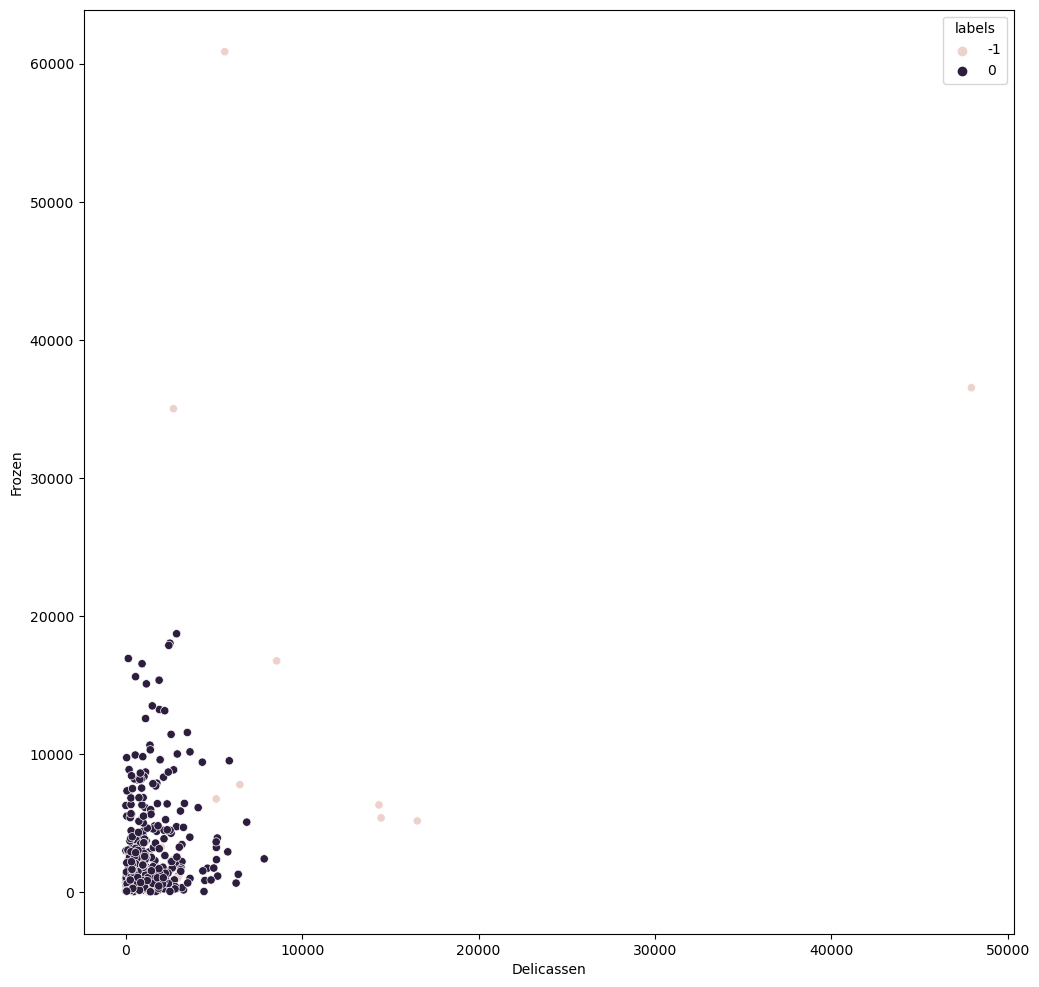

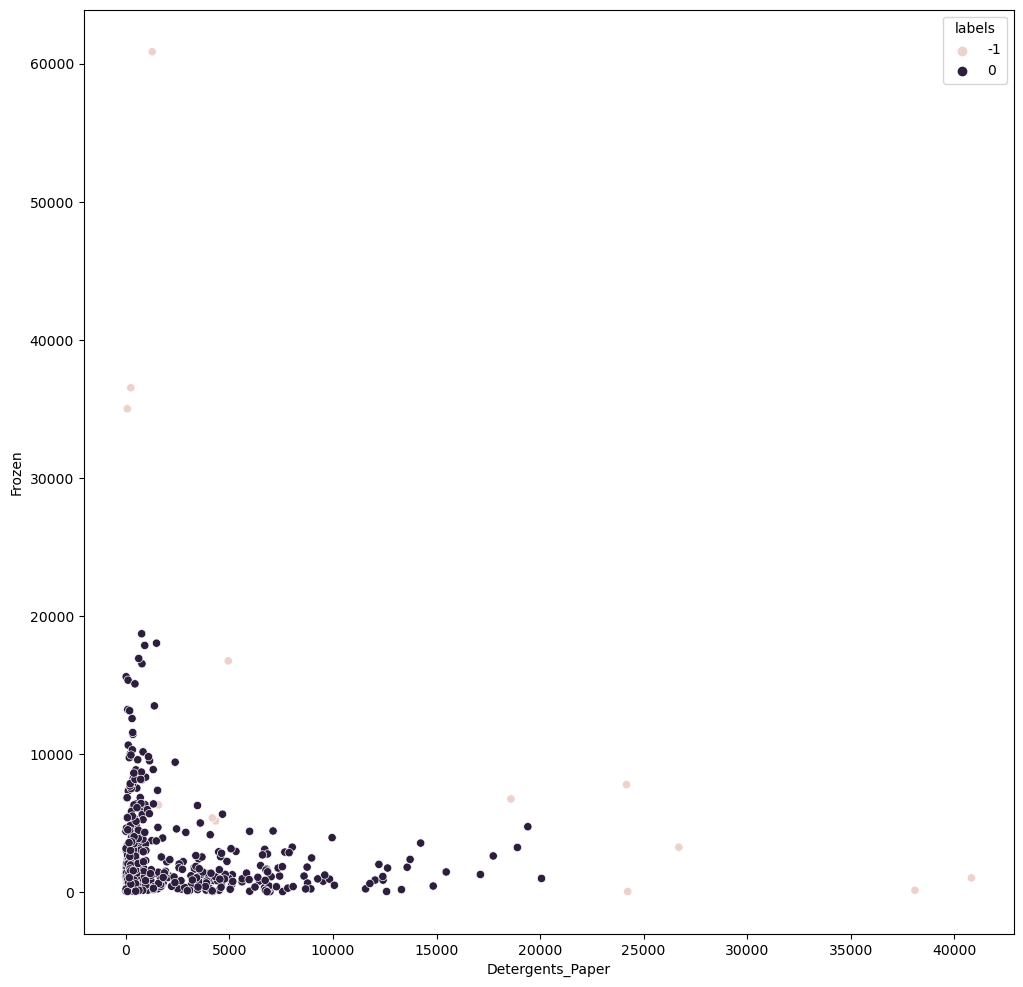

In [27]:
plt.figure(figsize=(12,12))
sns.scatterplot(x=df.Delicassen, y=df.Frozen, hue=df.labels)
plt.show()

plt.figure(figsize=(12,12))
sns.scatterplot(x=df.Detergents_Paper, y=df.Frozen, hue=df.labels)
plt.show()


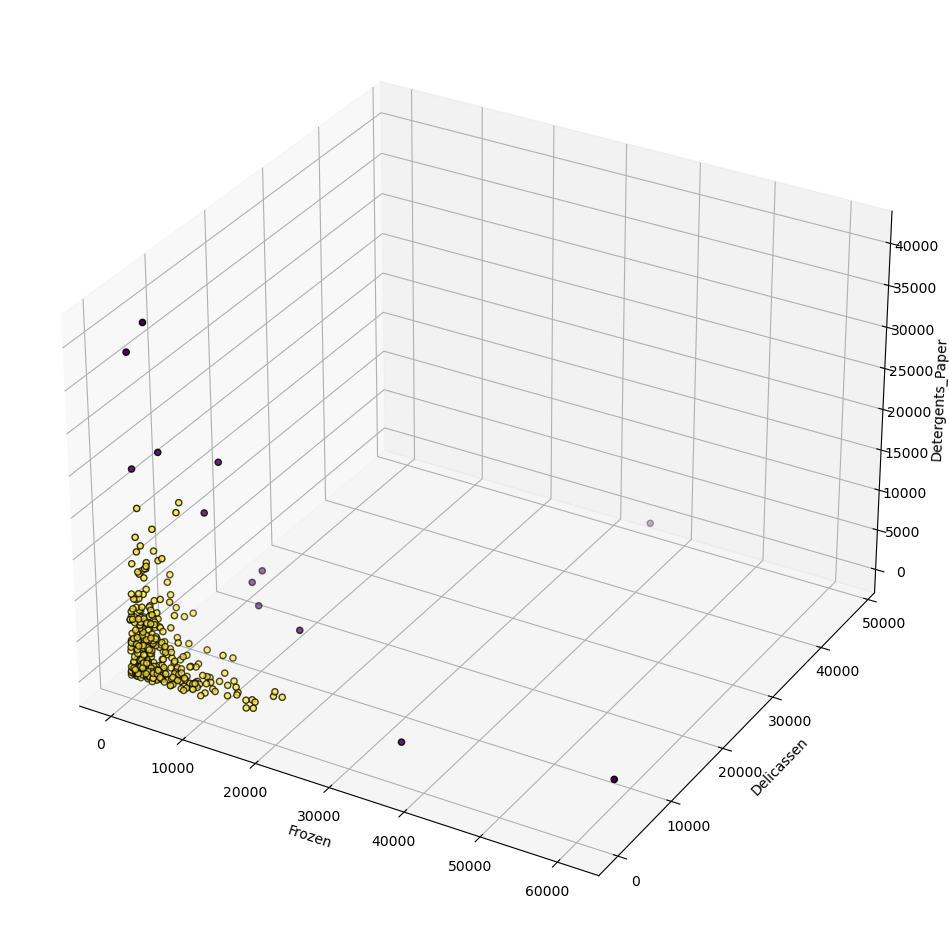

In [28]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# plot the points
ax.scatter(df['Frozen'], df['Delicassen'], df['Detergents_Paper'], c=df['labels'], edgecolor='k')

ax.set_xlabel('Frozen')
ax.set_ylabel('Delicassen')
ax.set_zlabel('Detergents_Paper')

plt.show()


In [29]:
url = f'mysql+pymysql://{env.username}:{env.password}@{env.host}/curriculum_logs'
query = '''
SELECT date,
       path as endpoint,
       user_id,
       cohort_id,
       ip as source_ip
FROM logs;
'''
df = pd.read_sql(query, url)
print(df.shape)
df

(900223, 5)


,date,endpoint,user_id,cohort_id,source_ip
0,2018-01-26,/,1,8.0,97.105.19.61
1,2018-01-26,java-ii,1,8.0,97.105.19.61
2,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61
...,...,...,...,...,...
900218,2021-04-21,jquery/personal-site,64,28.0,71.150.217.33
900219,2021-04-21,jquery/mapbox-api,64,28.0,71.150.217.33
900220,2021-04-21,jquery/ajax/weather-map,64,28.0,71.150.217.33
900221,2021-04-21,anomaly-detection/discrete-probabilistic-methods,744,28.0,24.160.137.86


In [30]:
id_counts = df.groupby('user_id')[['endpoint', 'date', 'cohort_id']].nunique()

In [31]:
id_counts.head()

,endpoint,date,cohort_id
user_id,,,
1,976,637,2
2,151,83,1
3,169,107,1
4,143,54,1
5,197,82,1


In [32]:
cohort_counts = df.groupby('cohort_id')[['user_id', 'endpoint', 'date']].nunique()
cohort_counts.tail(10)

,user_id,endpoint,date
cohort_id,,,
59.0,29,420,277
61.0,23,275,252
62.0,33,288,213
132.0,23,273,169
133.0,17,230,135
134.0,20,239,135
135.0,31,248,86
137.0,21,162,38
138.0,37,136,38


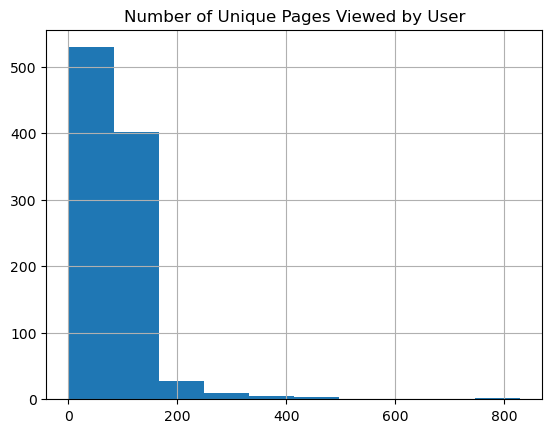

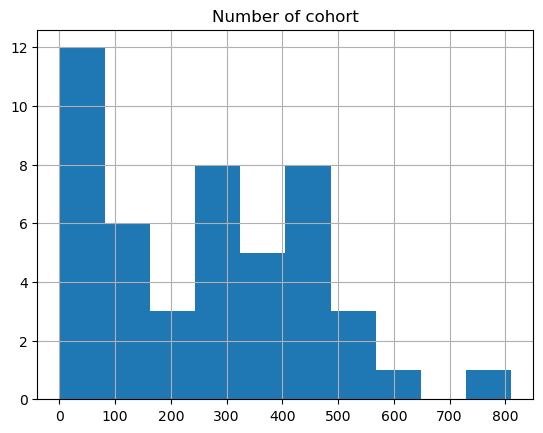

In [33]:
id_counts.date.hist()
plt.title('Number of Unique Pages Viewed by User')
plt.show()

cohort_counts.date.hist()
plt.title('Number of cohort')
plt.show()

In [34]:
df['date'] = pd.to_datetime(df['date'])

In [35]:
first_access = df.groupby('user_id').date.min()
first_access = first_access.reset_index()
first_access.columns = ['user_id', 'first_access']

In [36]:
first_access.head()

,user_id,first_access
0,1,2018-01-26
1,2,2018-01-26
2,3,2018-01-26
3,4,2018-01-26
4,5,2018-01-26


In [37]:
# aggregate based on the date to see where individual first access is:
first_access.groupby('first_access').user_id.count()

first_access
2018-01-26    50
2018-01-27     2
2018-01-28     2
2018-01-29    12
2018-01-30     7
              ..
2021-04-08     1
2021-04-11     1
2021-04-12    26
2021-04-13     1
2021-04-19     1
Name: user_id, Length: 251, dtype: int64

Text(0.5, 1.0, 'Number of First Access Counts Over Time')

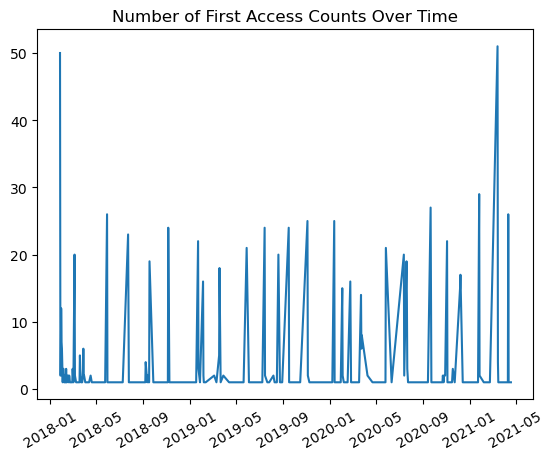

In [38]:
plt.plot(first_access.groupby('first_access').user_id.count())
plt.xticks(rotation=30)
plt.title('Number of First Access Counts Over Time')

In [39]:
# grab the page count, grab the unique page access (per user)
page_views = df.groupby('user_id')['endpoint'].agg(['count', 'nunique'])

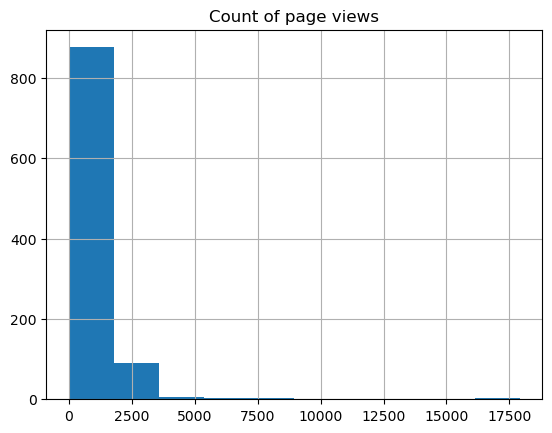

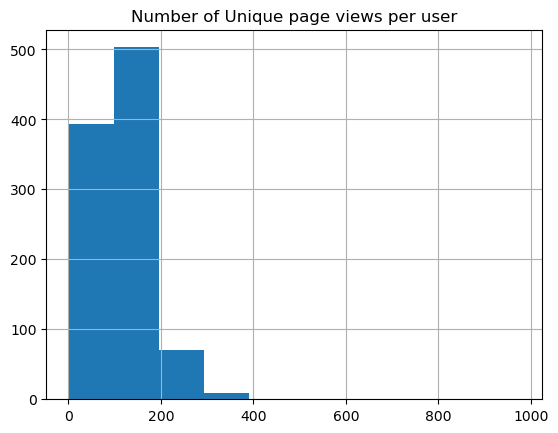

In [40]:
page_views['count'].hist()
plt.title('Count of page views')
plt.show()

page_views['nunique'].hist()
plt.title('Number of Unique page views per user')
plt.show()

In [41]:
# make and fit the thing
scaler = MinMaxScaler()
# use the thing
scaled_pages = scaler.fit_transform(page_views)
scaled_pages

array([[4.13298347e-01, 1.00000000e+00],
       [8.59758821e-02, 1.53846154e-01],
       [8.71482805e-02, 1.72307692e-01],
       ...,
       [7.03439035e-03, 1.94871795e-02],
       [1.11656990e-04, 0.00000000e+00],
       [2.28896829e-03, 8.20512821e-03]])

In [42]:
scaled_pages = pd.DataFrame(scaled_pages, 
                            index=page_views.index, 
                            columns=[n + '_scaled' for n in page_views.columns])
scaled_pages.head()

,count_scaled,nunique_scaled
user_id,,
1,0.413298,1.000000
2,0.085976,0.153846
3,0.087148,0.172308
4,0.038577,0.145641
5,0.094908,0.201026


In [43]:
pd.concat([page_views, scaled_pages], axis=1)

,count,nunique,count_scaled,nunique_scaled
user_id,,,,
1,7404,976,0.413298,1.000000
2,1541,151,0.085976,0.153846
3,1562,169,0.087148,0.172308
4,692,143,0.038577,0.145641
5,1701,197,0.094908,0.201026
...,...,...,...,...
977,86,12,0.004745,0.011282
978,55,18,0.003015,0.017436
979,127,20,0.007034,0.019487


In [44]:
# make the thing
db_clusters = DBSCAN(eps=0.075, min_samples=25)
# fit the thing
db_clusters.fit(scaled_pages)

DBSCAN(eps=0.075, min_samples=25)

In [45]:
page_views['label'] = db_clusters.labels_
page_views.label.value_counts()

 0    969
-1     12
Name: label, dtype: int64

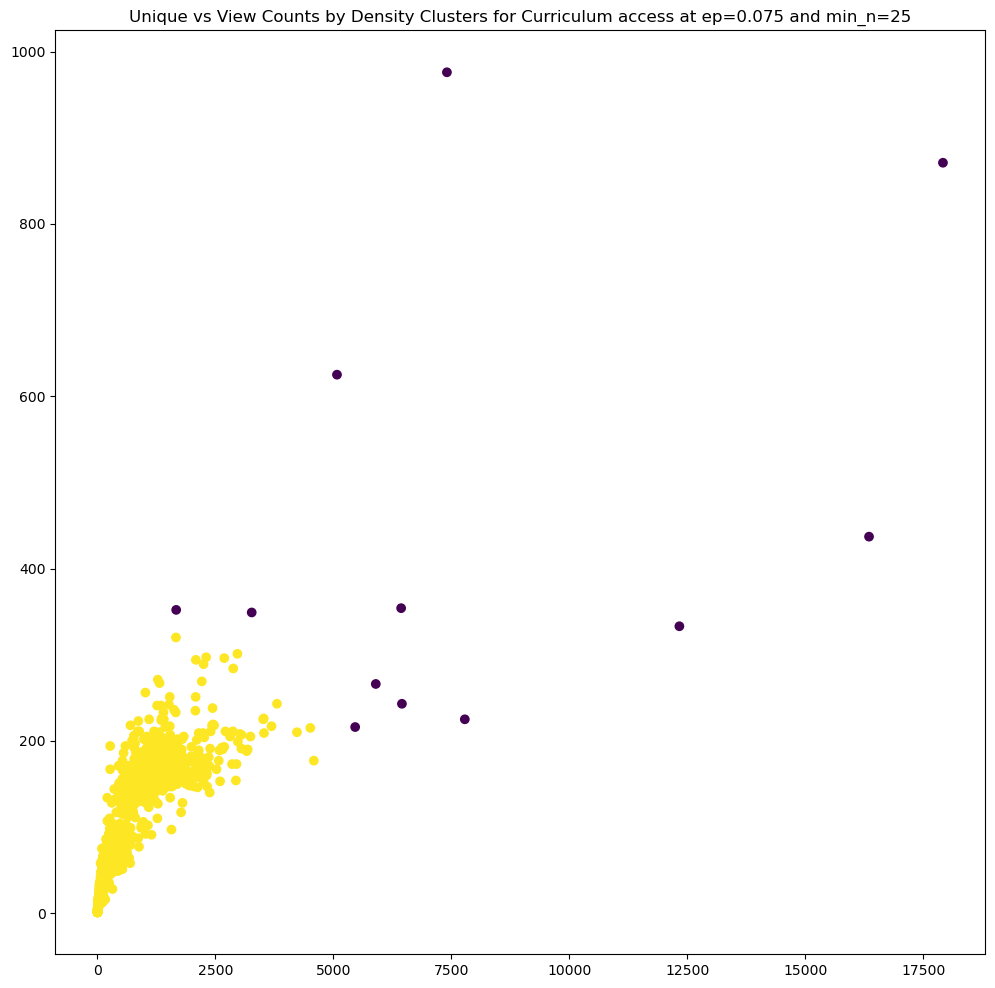

In [46]:
plt.figure(figsize=(12,12))
plt.scatter(page_views['count'], page_views['nunique'], c=page_views['label'])
plt.title('Unique vs View Counts by Density Clusters for Curriculum access at ep=0.075 and min_n=25')
plt.show()

In [47]:
# After some cleaning, calling the cleaner data without the nulls and dropping the top and bottom 1% when ranked by sqft.
df = w.prep_zillow(w.get_zillow_data())
df.head(3)

,id,bedrooms,bathrooms,sqft,yearbuilt,county,latitude,longitude,transaction_date,property_class,taxvalue,percentile_rank
0,76757,2,1.0,704,1923,LA,34290119.0,-118438171.0,2017-09-14,Single Family Residential,262138,0.010022
1,6554,2,1.0,704,1922,LA,33974852.0,-118295536.0,2017-01-30,Single Family Residential,247000,0.010022
2,8438,2,1.0,704,1924,LA,33850843.0,-118385100.0,2017-02-07,Single Family Residential,50490,0.010022


In [48]:
# setting id as the index and dropping the percentile column as it is no longer needed
df = df.set_index('id')
df.drop(['percentile_rank'], axis=1, inplace=True)
df.head(3)

,bedrooms,bathrooms,sqft,yearbuilt,county,latitude,longitude,transaction_date,property_class,taxvalue
id,,,,,,,,,,
76757,2,1.0,704,1923,LA,34290119.0,-118438171.0,2017-09-14,Single Family Residential,262138
6554,2,1.0,704,1922,LA,33974852.0,-118295536.0,2017-01-30,Single Family Residential,247000
8438,2,1.0,704,1924,LA,33850843.0,-118385100.0,2017-02-07,Single Family Residential,50490


In [49]:
# make and fit the thing on the ENTIRE DATA
scaler = MinMaxScaler()
# use the thing
scaled_zillow = scaler.fit_transform(df.drop(columns=['taxvalue','county','transaction_date', 'property_class']))
scaled_zillow

array([[0.18181818, 0.        , 0.        , 0.3961039 , 0.64751421,
        0.53381394],
       [0.18181818, 0.        , 0.        , 0.38961039, 0.43249616,
        0.60918414],
       [0.18181818, 0.        , 0.        , 0.4025974 , 0.34791967,
        0.56185735],
       ...,
       [0.45454545, 0.375     , 0.99934211, 0.56493506, 0.59835497,
        0.65878627],
       [0.27272727, 0.5625    , 1.        , 0.91558442, 0.08992624,
        0.93097446],
       [0.36363636, 0.375     , 1.        , 0.6038961 , 0.44265551,
        0.748812  ]])

In [50]:
scaled_zillow = pd.DataFrame(scaled_zillow, 
                             index=df.index, 
                             columns=['bedrooms_scaled', 'bathrooms_scaled', 'sqft_scaled', 'yearbuilt_scaled', 'latitude_scaled', 'longitude_scaled'])
scaled_zillow

,bedrooms_scaled,bathrooms_scaled,sqft_scaled,yearbuilt_scaled,latitude_scaled,longitude_scaled
id,,,,,,
76757,0.181818,0.0000,0.000000,0.396104,0.647514,0.533814
6554,0.181818,0.0000,0.000000,0.389610,0.432496,0.609184
8438,0.181818,0.0000,0.000000,0.402597,0.347920,0.561857
382,0.090909,0.0000,0.000000,0.558442,0.723773,0.339797
17297,0.090909,0.0000,0.000000,0.480519,0.613290,0.580760
...,...,...,...,...,...,...
41859,0.272727,0.4375,0.997807,0.714286,0.191282,0.834915
18038,0.363636,0.2500,0.998246,0.915584,0.877361,0.645773
36084,0.454545,0.3750,0.999342,0.564935,0.598355,0.658786


In [51]:
pd.concat([df, scaled_zillow], axis=1)

,bedrooms,bathrooms,sqft,yearbuilt,county,latitude,longitude,transaction_date,property_class,taxvalue,bedrooms_scaled,bathrooms_scaled,sqft_scaled,yearbuilt_scaled,latitude_scaled,longitude_scaled
id,,,,,,,,,,,,,,,,
76757,2,1.0,704,1923,LA,34290119.0,-118438171.0,2017-09-14,Single Family Residential,262138,0.181818,0.0000,0.000000,0.396104,0.647514,0.533814
6554,2,1.0,704,1922,LA,33974852.0,-118295536.0,2017-01-30,Single Family Residential,247000,0.181818,0.0000,0.000000,0.389610,0.432496,0.609184
8438,2,1.0,704,1924,LA,33850843.0,-118385100.0,2017-02-07,Single Family Residential,50490,0.181818,0.0000,0.000000,0.402597,0.347920,0.561857
382,1,1.0,704,1948,Ventura,34401933.0,-118805341.0,2017-01-03,Single Family Residential,248915,0.090909,0.0000,0.000000,0.558442,0.723773,0.339797
17297,1,1.0,704,1936,LA,34239938.0,-118349327.0,2017-03-15,Single Family Residential,343565,0.090909,0.0000,0.000000,0.480519,0.613290,0.580760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41859,3,4.5,5254,1972,Orange,33621175.0,-117868350.0,2017-05-31,Single Family Residential,3532887,0.272727,0.4375,0.997807,0.714286,0.191282,0.834915
18038,4,3.0,5256,2003,LA,34627129.0,-118226293.0,2017-03-17,Single Family Residential,408898,0.363636,0.2500,0.998246,0.915584,0.877361,0.645773
36084,5,4.0,5261,1949,LA,34218040.0,-118201666.0,2017-05-15,Single Family Residential,1474459,0.454545,0.3750,0.999342,0.564935,0.598355,0.658786


In [52]:
# make the thing
db_clusters = DBSCAN(eps=0.085, min_samples=50)
# fit the thing
db_clusters.fit(scaled_zillow)

DBSCAN(eps=0.085, min_samples=50)

In [53]:
df['label'] = db_clusters.labels_
df.label.value_counts()

 1     20746
-1     12600
 4     11917
 0      6966
 3       795
 8       405
 11      381
 6       185
 12      167
 7       156
 5        72
 2        71
 10       55
 9        48
Name: label, dtype: int64

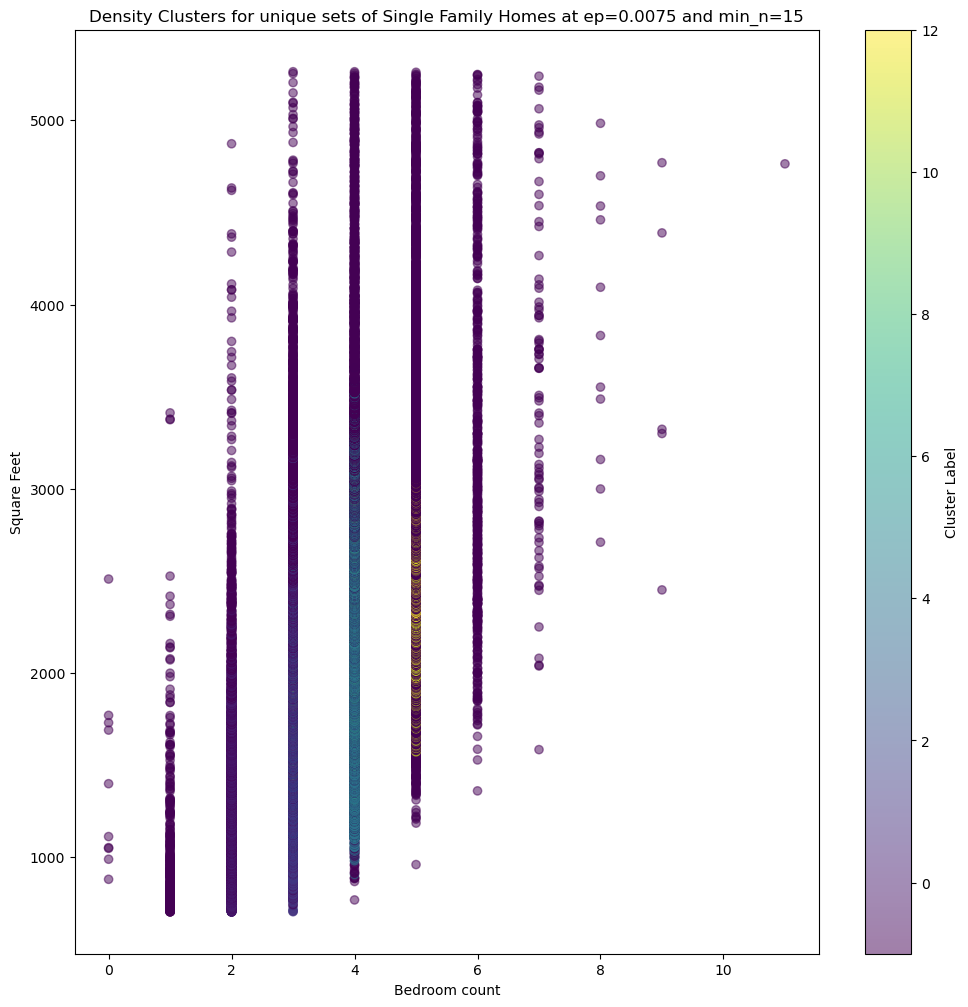

In [54]:
plt.figure(figsize=(12,12))

# Create the scatter plot and capture the output in a variable
scatter = plt.scatter(df['bedrooms'], df['sqft'], marker='o', c=df['label'], alpha=0.5)

# Add a color bar which acts as a legend for the 'label' colors
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster Label')

# Set the title and labels
plt.title('Density Clusters for unique sets of Single Family Homes at ep=0.0075 and min_n=15')
plt.xlabel('Bedroom count')
plt.ylabel('Square Feet')

# Display the plot
plt.show()


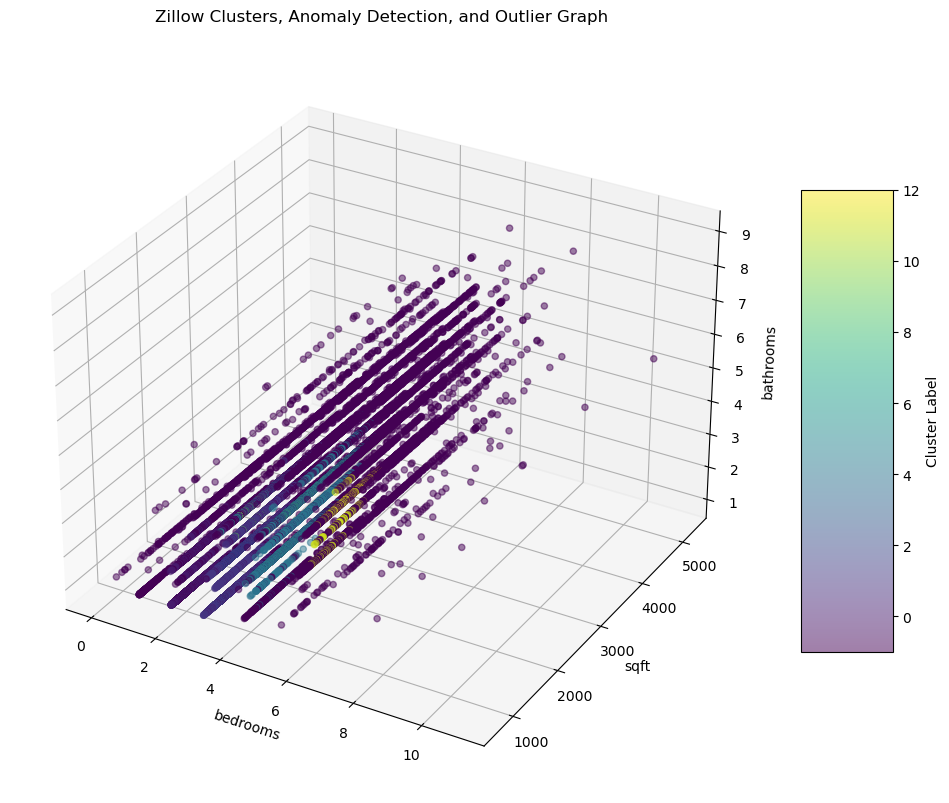

In [55]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# Choose a color map
color_map = plt.get_cmap('viridis')

# Plot the points with the specified color map and make them semi-transparent with the alpha parameter
sc = ax.scatter(df['bedrooms'], df['sqft'], df['bathrooms'], c=df['label'], cmap=color_map, alpha=0.5)

# Create a color bar
cbar = plt.colorbar(sc, shrink=0.5, aspect=5)
cbar.set_label('Cluster Label')

ax.set_xlabel('bedrooms')
ax.set_ylabel('sqft')
ax.set_zlabel('bathrooms')

# Set the title for the plot
ax.set_title('Zillow Clusters, Anomaly Detection, and Outlier Graph', pad=20)

plt.show()

In [56]:
# make the thing
db_clusters = DBSCAN(eps=0.01, min_samples=20)
# fit the thing
db_clusters.fit(scaled_zillow)

DBSCAN(eps=0.01, min_samples=20)

In [57]:
df['label'] = db_clusters.labels_
df.label.value_counts()

-1    54410
 1       46
 4       30
 3       29
 0       27
 2       22
Name: label, dtype: int64

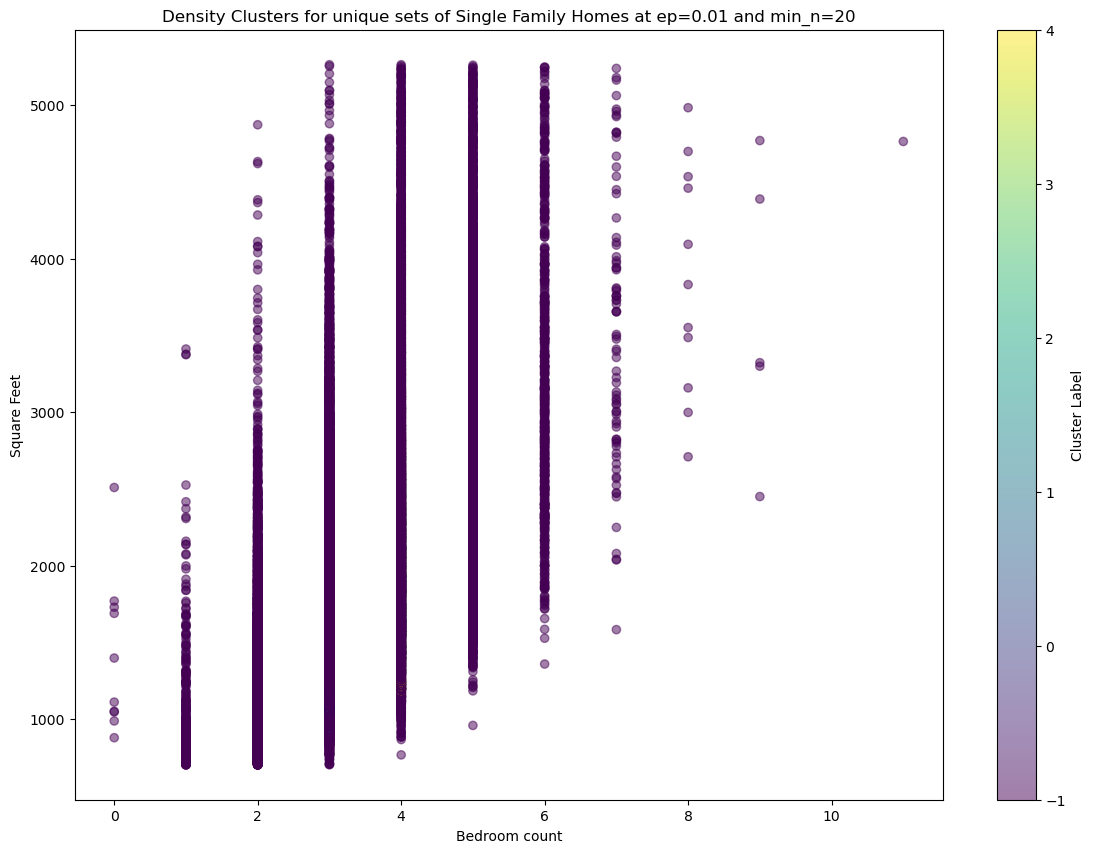

In [58]:
plt.figure(figsize=(14,10))

# Create the scatter plot and capture the output in a variable
scatter = plt.scatter(df['bedrooms'], df['sqft'], marker='o', c=df['label'], alpha=0.5)

# Add a color bar which acts as a legend for the 'label' colors
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster Label')

# Set the title and labels
plt.title('Density Clusters for unique sets of Single Family Homes at ep=0.01 and min_n=20')
plt.xlabel('Bedroom count')
plt.ylabel('Square Feet')

# Display the plot
plt.show()


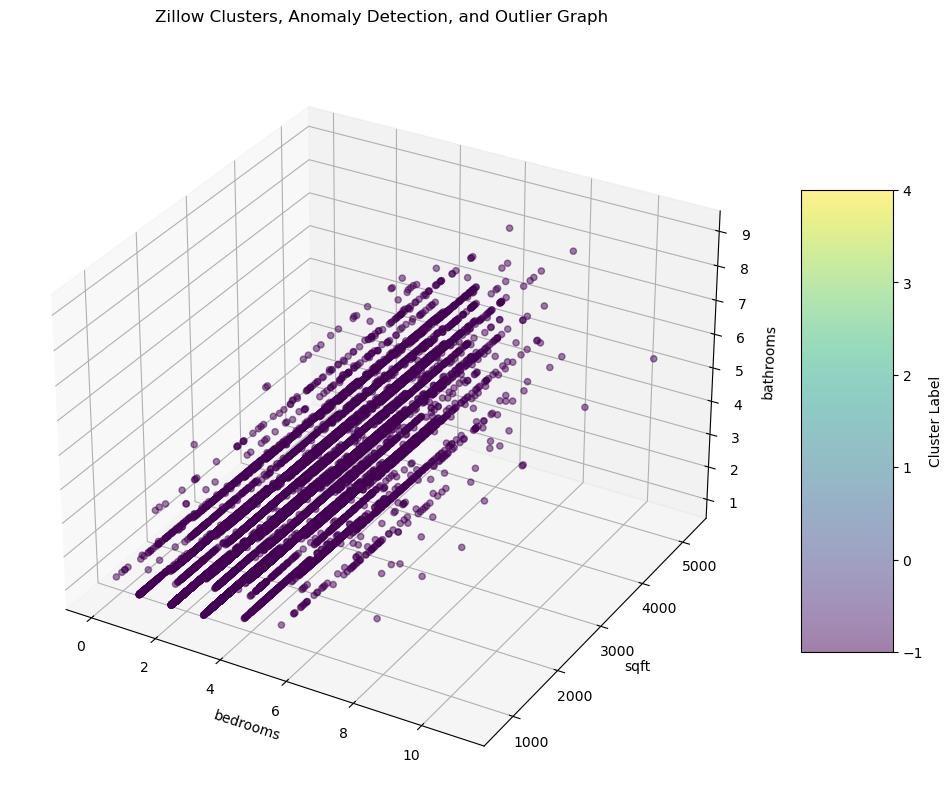

In [59]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# Choose a color map
color_map = plt.get_cmap('viridis')

# Plot the points with the specified color map and make them semi-transparent with the alpha parameter
sc = ax.scatter(df['bedrooms'], df['sqft'], df['bathrooms'], c=df['label'], cmap=color_map, alpha=0.5)

# Create a color bar
cbar = plt.colorbar(sc, shrink=0.5, aspect=5)
cbar.set_label('Cluster Label')

ax.set_xlabel('bedrooms')
ax.set_ylabel('sqft')
ax.set_zlabel('bathrooms')

# Set the title for the plot
ax.set_title('Zillow Clusters, Anomaly Detection, and Outlier Graph', pad=20)

plt.show()